In [29]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from pathlib import Path

import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind_from_stats

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
base_path_data = '../Data'
base_path_results = '../results'

In [20]:
# print out the contents at base_path_results
print(os.listdir(base_path_results))

['hup_univar_feats_eld.csv', 'hup_univar_feats_reg.csv', 'mni_univar_feats_reg.csv', 'mni_univar_feats_eld.csv']


In [21]:
hup_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg.csv'))
mni_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg.csv'))

GLOBAL COMPARISON

In [43]:
def check_normality(hup_data, mni_data, feature_name):
   """
   Test and visualize normality of distributions for a given feature
   
   Args:
       hup_data: Feature values from HUP dataset
       mni_data: Feature values from MNI dataset
       feature_name: Name of feature being analyzed
   
   Returns:
       tuple: (is_hup_normal, is_mni_normal) boolean values
   """
   # Shapiro-Wilk test
   _, hup_p = stats.shapiro(hup_data)
   _, mni_p = stats.shapiro(mni_data)
   
#    plt.figure(figsize=(12, 4))
#    plt.subplot(121)
#    sns.histplot(hup_data, label='HUP')
#    plt.title(f'HUP {feature_name}\nShapiro p={hup_p:.3f}')
   
#    plt.subplot(122)
#    sns.histplot(mni_data, label='MNI')
#    plt.title(f'MNI {feature_name}\nShapiro p={mni_p:.3f}')
#    plt.show()
   
   return hup_p > 0.05, mni_p > 0.05

def compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg):
    results = []
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        hup_data = hup_univar_feats_reg[feature]
        mni_data = mni_univar_feats_reg[feature]
        
        # Normality tests
        _, hup_p = stats.shapiro(hup_data)
        _, mni_p = stats.shapiro(mni_data)
        
        print(f"\nFeature: {feature}")
        print(f"HUP normality p-value: {hup_p:.3f}")
        print(f"MNI normality p-value: {mni_p:.3f}")
        
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_data, mni_data)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_data, mni_data, alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        results.append({
            'feature': feature,
            'test': test_name,
            'statistic': stat,
            'p_value': p_val
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison corrections
    results_df['p_value_bonferroni'] = np.minimum(results_df['p_value'] * len(results_df), 1)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

def interpret_global_results(global_results, alpha=0.05):
    """
    Interpret statistical test results with clear print statements
    
    Args:
        global_results: DataFrame with statistical test results
        alpha: Significance level (default 0.05)
    """
    print("\nInterpretation of Statistical Tests:")
    print("=====================================")
    
    # Sort by FDR-corrected p-values
    results_sorted = global_results.sort_values('p_value_fdr')
    
    for _, row in results_sorted.iterrows():
        feature = row['feature']
        test = row['test']
        p_fdr = row['p_value_fdr']
        
        print(f"\nFeature: {feature}")
        print(f"Test used: {test}")
        
        if p_fdr < alpha:
            print(f"Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p={p_fdr:.6f})")
            # print("Interpretation: There is strong evidence for a difference between sites")
        else:
            print(f"Result: NO significant difference between HUP and MNI (FDR-corrected p={p_fdr:.6f})")
            # print("Interpretation: No strong evidence for a difference between sites")

    # Summary
    n_significant = sum(results_sorted['p_value_fdr'] < alpha)
    print(f"\nSummary:")
    print(f"- {n_significant} out of {len(results_sorted)} features show significant differences between sites")
    print(f"- Most significant differences found in: {', '.join(results_sorted.head(3)['feature'].tolist())}")
    if n_significant < len(results_sorted):
        print(f"- Features with NO significant differences: {', '.join(results_sorted[results_sorted['p_value_fdr'] >= alpha]['feature'].tolist())}")

In [35]:
print("Checking normality for each feature:")
normality_results = {}
for feature in hup_univar_feats_reg.filter(like='mean').columns:
    print(f"\nAnalyzing {feature}:")
    is_normal_hup, is_normal_mni = check_normality(
        hup_univar_feats_reg[feature],
        mni_univar_feats_reg[feature],
        feature
    )
    normality_results[feature] = {
        'HUP_normal': is_normal_hup,
        'MNI_normal': is_normal_mni
    }
    # Add print statements
    print(f"HUP normality test: {'Normal' if is_normal_hup else 'Not normal'}")
    print(f"MNI normality test: {'Normal' if is_normal_mni else 'Not normal'}")

Checking normality for each feature:

Analyzing deltaRel_mean:
HUP normality test: Normal
MNI normality test: Normal

Analyzing thetaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing alphaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing betaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing gammaRel_mean:
HUP normality test: Normal
MNI normality test: Normal

Analyzing entropy_1min_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing entropy_fullts_mean:
HUP normality test: Not normal
MNI normality test: Normal


In [36]:
## Statistical testing - global comparison

global_results = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)

print("\nGlobal comparison results:")
print(global_results.sort_values('p_value_fdr'))

#global_results.to_csv('global_comparison_results.csv', index=False)


Feature: deltaRel_mean
HUP normality p-value: 0.551
MNI normality p-value: 0.961

Feature: thetaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.953

Feature: alphaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.778

Feature: betaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.289

Feature: gammaRel_mean
HUP normality p-value: 0.107
MNI normality p-value: 0.685

Feature: entropy_1min_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.152

Feature: entropy_fullts_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.150

Global comparison results:
               feature            test    statistic       p_value  \
3         betaRel_mean  Mann-Whitney U  1063.000000  1.167849e-09   
0        deltaRel_mean          t-test     5.899713  2.549665e-08   
5    entropy_1min_mean  Mann-Whitney U  3741.000000  3.692585e-06   
6  entropy_fullts_mean  Mann-Whitney U  3741.000000  3.692585e-06   
1        thetaRel_mean  Mann-Whitney U  3289

In [44]:
interpret_global_results(global_results)


Interpretation of Statistical Tests:

Feature: betaRel_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000000)
Interpretation: There is strong evidence for a difference between sites

Feature: deltaRel_mean
Test used: t-test
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000000)
Interpretation: There is strong evidence for a difference between sites

Feature: entropy_1min_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000006)
Interpretation: There is strong evidence for a difference between sites

Feature: entropy_fullts_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000006)
Interpretation: There is strong evidence for a difference between sites

Feature: thetaRel_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.006740)
Interpretation: There is strong e

In [48]:
# Calculate and print effect sizes
def print_effect_sizes(hup_univar_feats_reg, mni_univar_feats_reg):
    print("\nEffect Sizes (Cohen's d):")
    print("=======================")
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        effect_size = (np.mean(hup_univar_feats_reg[feature]) - np.mean(mni_univar_feats_reg[feature])) / \
                     np.sqrt((np.var(hup_univar_feats_reg[feature]) + np.var(mni_univar_feats_reg[feature])) / 2)
        
        print(f"{feature}: {effect_size:.3f}")
        # Interpret effect size
        if abs(effect_size) < 0.2:
            print("Interpretation: Negligible effect")
        elif abs(effect_size) < 0.5:
            print("Interpretation: Small effect")
        elif abs(effect_size) < 0.8:
            print("Interpretation: Medium effect")
        else:
            print("Interpretation: Large effect")
        print()

In [69]:
def print_effect_sizes(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Print and interpret effect sizes for all features
    """
    print("\nEffect Size Analysis:")
    print("====================")
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        # Calculate effect size
        effect_size = (np.mean(hup_univar_feats_reg[feature]) - np.mean(mni_univar_feats_reg[feature])) / \
                     np.sqrt((np.var(hup_univar_feats_reg[feature]) + np.var(mni_univar_feats_reg[feature])) / 2)
        
        print(f"\nFeature: {feature}")
        print(f"Effect Size: {effect_size:.3f}")
        
        # Interpret effect size
        if abs(effect_size) < 0.2:
            interpretation = "Negligible effect"
        elif abs(effect_size) < 0.5:
            interpretation = "Small effect"
        elif abs(effect_size) < 0.8:
            interpretation = "Medium effect"
        else:
            interpretation = "Large effect"
        
        print(f"Interpretation: {interpretation}")
        print(f"HUP mean: {np.mean(hup_univar_feats_reg[feature]):.3f}")
        print(f"MNI mean: {np.mean(mni_univar_feats_reg[feature]):.3f}")

def plot_feature_comparison(hup_univar_feats_reg, mni_univar_feats_reg, global_results):
    plt.figure(figsize=(15, 6))
    
    # Colors
    mni_color = 'navy'
    hup_color = 'skyblue'
    
    # Get features
    features = ['deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 
               'betaRel_mean', 'gammaRel_mean', 
               'entropy_1min_mean', 'entropy_fullts_mean']
    
    positions = np.arange(len(features))
    width = 0.35
    
    for i, feature in enumerate(features):
        # Calculate statistics
        hup_data = hup_univar_feats_reg[feature]
        mni_data = mni_univar_feats_reg[feature]
        
        # Plot violins
        vplot1 = plt.violinplot(mni_data, positions=[positions[i]-width/2])
        for pc in vplot1['bodies']:
            pc.set_facecolor(mni_color)
            pc.set_alpha(0.7)
        
        vplot2 = plt.violinplot(hup_data, positions=[positions[i]+width/2])
        for pc in vplot2['bodies']:
            pc.set_facecolor(hup_color)
            pc.set_alpha(0.7)
        
        # Add points
        plt.scatter(np.repeat(positions[i]-width/2, len(mni_data)), 
                   mni_data, color=mni_color, alpha=0.2, s=5)
        plt.scatter(np.repeat(positions[i]+width/2, len(hup_data)), 
                   hup_data, color=hup_color, alpha=0.2, s=5)
        
        # Add effect size and significance
        effect_size = (np.mean(hup_data) - np.mean(mni_data)) / \
                     np.sqrt((np.var(hup_data) + np.var(mni_data)) / 2)
        
        result = global_results[global_results['feature'] == feature].iloc[0]
        if result['p_value_fdr'] < 0.001:
            sig = '***'
        elif result['p_value_fdr'] < 0.01:
            sig = '**'
        elif result['p_value_fdr'] < 0.05:
            sig = '*'
        else:
            sig = 'ns'
            
        plt.text(positions[i], plt.ylim()[1], 
                f'{sig}\nES={effect_size:.2f}', 
                ha='center', va='bottom')
    
    # Labels and formatting
    plt.xlabel('Features')
    plt.ylabel('Relative band power')
    plt.title('Feature Comparison between HUP and MNI sites')
    
    # Set x-ticks
    plt.xticks(positions, 
               ['delta', 'theta', 'alpha', 'beta', 'gamma', 
                'entropy_1min', 'entropy_fullts'], 
               rotation=45)
    
    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=mni_color, lw=4, label='MNI'),
                   Line2D([0], [0], color=hup_color, lw=4, label='HUP')]
    plt.legend(handles=custom_lines, loc='upper right')
    
    # Add significance legend
    plt.text(1.05, 0.95, 
            '*** p<0.001\n** p<0.01\n* p<0.05\nns: not significant',
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', edgecolor='none'))
    
    plt.tight_layout()
    plt.show()

Effect size (ES) measures the magnitude of difference between two groups
We're using Cohen's d: d = (M₁ - M₂) / sqrt((s₁² + s₂²)/2)
M₁, M₂: means of the two groups
s₁², s₂²: variances of the two groups s.t.

|d| < 0.2: negligible effect
0.2 ≤ |d| < 0.5: small effect
0.5 ≤ |d| < 0.8: medium effect
|d| ≥ 0.8: large effect

In [66]:
print_effect_sizes(hup_univar_feats_reg, mni_univar_feats_reg)


Effect Size Analysis:

Feature: deltaRel_mean
Effect Size: 0.993
Interpretation: Large effect
HUP mean: 0.197
MNI mean: 0.180

Feature: thetaRel_mean
Effect Size: 0.222
Interpretation: Small effect
HUP mean: 0.171
MNI mean: 0.169

Feature: alphaRel_mean
Effect Size: -0.400
Interpretation: Small effect
HUP mean: 0.151
MNI mean: 0.157

Feature: betaRel_mean
Effect Size: -0.774
Interpretation: Medium effect
HUP mean: 0.148
MNI mean: 0.161

Feature: gammaRel_mean
Effect Size: -0.121
Interpretation: Negligible effect
HUP mean: 0.097
MNI mean: 0.099

Feature: entropy_1min_mean
Effect Size: 0.750
Interpretation: Medium effect
HUP mean: 0.667
MNI mean: 0.665

Feature: entropy_fullts_mean
Effect Size: 0.751
Interpretation: Medium effect
HUP mean: 0.796
MNI mean: 0.794


CHECKING FOR OUTLIERS (GLOBAL COMPARISON)

In [67]:
def detect_outliers(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Detect outliers using multiple methods
    """
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        print(f"\nAnalyzing outliers for {feature}")
        
        # 1. IQR method
        def get_iqr_outliers(data):
            Q1 = np.percentile(data, 25)
            Q3 = np.percentile(data, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            return outliers
        
        hup_outliers_iqr = get_iqr_outliers(hup_univar_feats_reg[feature])
        mni_outliers_iqr = get_iqr_outliers(mni_univar_feats_reg[feature])
        
        # 2. Z-score method
        def get_zscore_outliers(data, threshold=3):
            z_scores = np.abs(stats.zscore(data))
            outliers = data[z_scores > threshold]
            return outliers
        
        hup_outliers_z = get_zscore_outliers(hup_univar_feats_reg[feature])
        mni_outliers_z = get_zscore_outliers(mni_univar_feats_reg[feature])
        
        print(f"HUP IQR outliers: {len(hup_outliers_iqr)}")
        print(f"MNI IQR outliers: {len(mni_outliers_iqr)}")
        print(f"HUP Z-score outliers: {len(hup_outliers_z)}")
        print(f"MNI Z-score outliers: {len(mni_outliers_z)}")
        
        # Visualize with boxplot
        plt.figure(figsize=(8,4))
        plt.boxplot([hup_univar_feats_reg[feature], mni_univar_feats_reg[feature]], 
                   tick_labels=['HUP', 'MNI'])
        plt.title(f'{feature}')
        plt.show()

# Robust statistical comparison
def compare_sites_robustly(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Perform robust statistical comparisons
    """
    results = []
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        hup_data = hup_univar_feats_reg[feature]
        mni_data = mni_univar_feats_reg[feature]
        
        # 1. Robust t-test (Yuen's test)
                
        # 2. Non-parametric test (already using Mann-Whitney U)
        stat_mw, p_val_mw = stats.mannwhitneyu(hup_data, mni_data, alternative='two-sided')
        
        # 3. Robust effect size (Cliff's Delta)
        def cliffs_delta(x, y):
            nx = len(x)
            ny = len(y)
            delta = 0
            for i in x:
                for j in y:
                    if i > j:
                        delta += 1
                    elif i < j:
                        delta -= 1
            delta = delta / (nx * ny)
            return delta
        
        effect_size = cliffs_delta(hup_data, mni_data)
        
        results.append({
            'feature': feature,
            'mannwhitney_stat': stat_mw,
            'mannwhitney_p': p_val_mw,
            'cliffs_delta': effect_size
        })
    
    return pd.DataFrame(results)


Analyzing outliers for deltaRel_mean
HUP IQR outliers: 0
MNI IQR outliers: 1
HUP Z-score outliers: 0
MNI Z-score outliers: 0


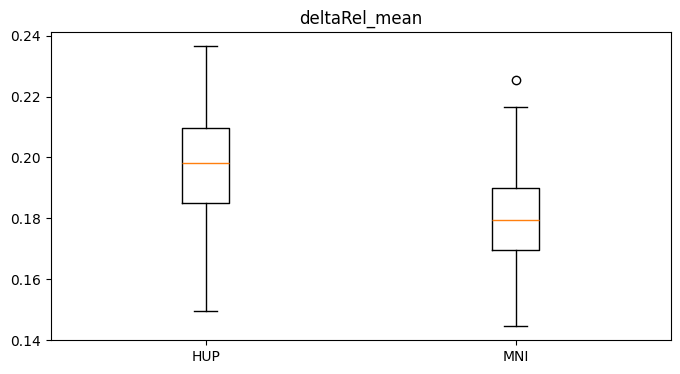


Analyzing outliers for thetaRel_mean
HUP IQR outliers: 2
MNI IQR outliers: 0
HUP Z-score outliers: 1
MNI Z-score outliers: 0


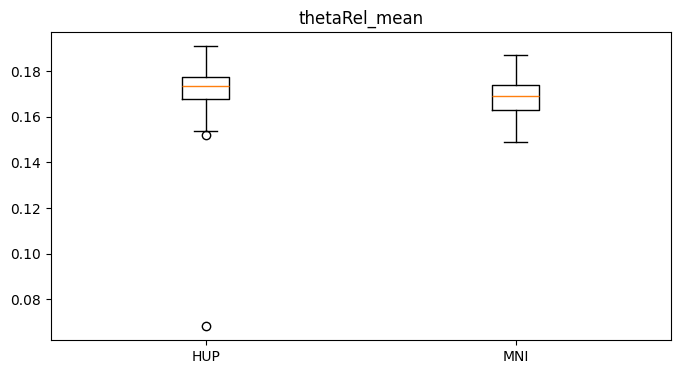


Analyzing outliers for alphaRel_mean
HUP IQR outliers: 1
MNI IQR outliers: 1
HUP Z-score outliers: 1
MNI Z-score outliers: 1


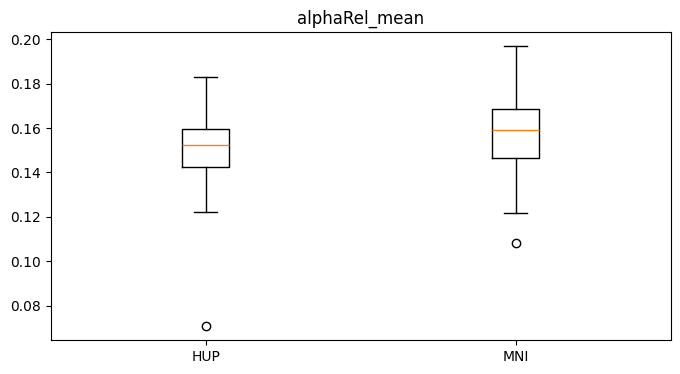


Analyzing outliers for betaRel_mean
HUP IQR outliers: 2
MNI IQR outliers: 2
HUP Z-score outliers: 1
MNI Z-score outliers: 1


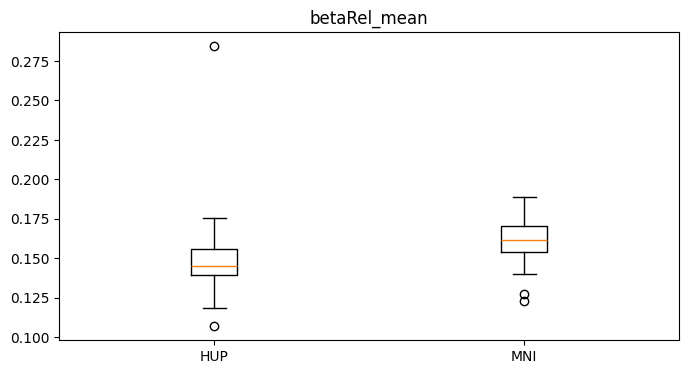


Analyzing outliers for gammaRel_mean
HUP IQR outliers: 3
MNI IQR outliers: 0
HUP Z-score outliers: 0
MNI Z-score outliers: 0


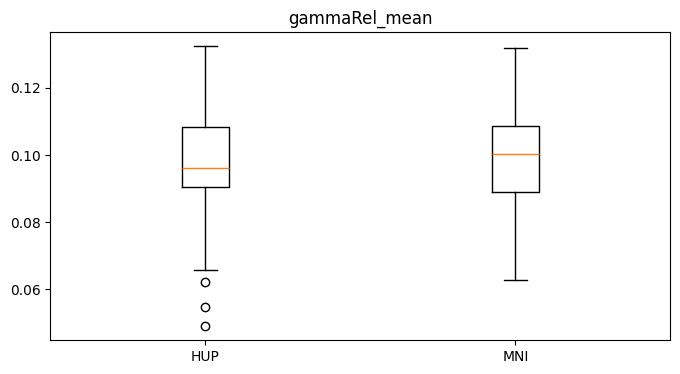


Analyzing outliers for entropy_1min_mean
HUP IQR outliers: 1
MNI IQR outliers: 5
HUP Z-score outliers: 1
MNI Z-score outliers: 1


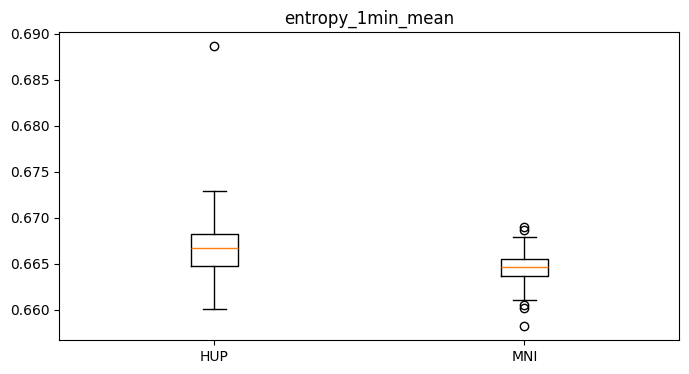


Analyzing outliers for entropy_fullts_mean
HUP IQR outliers: 1
MNI IQR outliers: 5
HUP Z-score outliers: 1
MNI Z-score outliers: 1


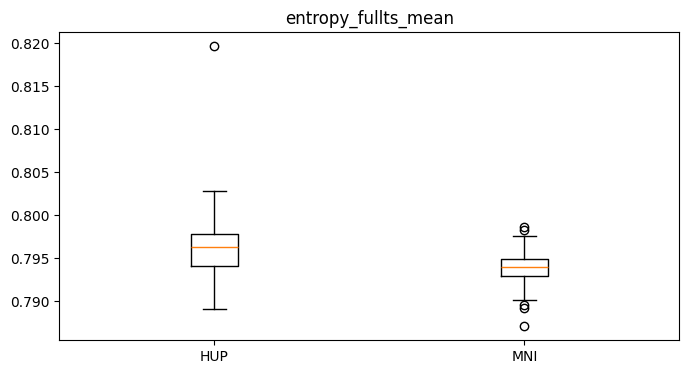

In [68]:
detect_outliers(hup_univar_feats_reg, mni_univar_feats_reg)
robust_results = compare_sites_robustly(hup_univar_feats_reg, mni_univar_feats_reg)

REGION-LEVEL COMPARISON

In [76]:
def analyze_roi_differences(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Perform ROI-level analysis and output most/least similar regions
    """
    # Initialize results storage
    results = []
    
    # Features to analyze
    spectral_features = ['deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 
                        'betaRel_mean', 'gammaRel_mean']
    entropy_features = ['entropy_1min_mean', 'entropy_fullts_mean']
    
    # Get common ROIs
    common_rois = set(hup_univar_feats_reg['roi']).intersection(set(mni_univar_feats_reg['roi']))
    
    for roi in common_rois:
        hup_roi_data = hup_univar_feats_reg[hup_univar_feats_reg['roi'] == roi]
        mni_roi_data = mni_univar_feats_reg[mni_univar_feats_reg['roi'] == roi]
        
        for feature in spectral_features + entropy_features:
            # Test for normality (Shapiro-Wilk test)
            _, hup_norm_p = stats.shapiro(hup_roi_data[feature])
            _, mni_norm_p = stats.shapiro(mni_roi_data[feature])
            
            # Choose test based on normality
            if hup_norm_p > 0.05 and mni_norm_p > 0.05:
                # For normal distributions: Independent t-test
                stat, p_val = stats.ttest_ind(hup_roi_data[feature], mni_roi_data[feature])
                test_name = "t-test"
            else:
                # For non-normal: Mann-Whitney U test
                stat, p_val = stats.mannwhitneyu(hup_roi_data[feature], 
                                               mni_roi_data[feature], 
                                               alternative='two-sided')
                test_name = "Mann-Whitney U"
            
            # Calculate effect size (Cohen's d)
            effect_size = (np.mean(hup_roi_data[feature]) - np.mean(mni_roi_data[feature])) / \
                         np.sqrt((np.var(hup_roi_data[feature]) + np.var(mni_roi_data[feature])) / 2)
            
            results.append({
                'roi': roi,
                'feature': feature,
                'test_used': test_name,
                'p_value': p_val,
                'effect_size': effect_size,
                'hup_mean': np.mean(hup_roi_data[feature]),
                'mni_mean': np.mean(mni_roi_data[feature]),
                'abs_difference': abs(np.mean(hup_roi_data[feature]) - np.mean(mni_roi_data[feature])),
                'n_hup': len(hup_roi_data),
                'n_mni': len(mni_roi_data)
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Multiple comparison correction using Bonferroni
    results_df['p_value_bonf'] = np.minimum(results_df['p_value'] * len(results_df), 1.0)
    
    # Print summary of results
    print("\nSummary of Statistical Analysis:")
    print("--------------------------------")
    print(f"Total ROIs compared: {len(common_rois)}")
    print(f"Total features analyzed: {len(spectral_features + entropy_features)}")
    print(f"Total comparisons made: {len(results_df)}")
    
    # Sort by absolute difference and get top/bottom 10
    results_df_sorted = results_df.sort_values('abs_difference', ascending=False)
    
    print("\nTop 10 Most Different ROI-Feature Combinations:")
    print("---------------------------------------------")
    top_10 = results_df_sorted.head(10)
    for _, row in top_10.iterrows():
        print(f"\nROI: {row['roi']}")
        print(f"Feature: {row['feature']}")
        print(f"HUP mean: {row['hup_mean']:.3f} (n={row['n_hup']})")
        print(f"MNI mean: {row['mni_mean']:.3f} (n={row['n_mni']})")
        print(f"Effect size: {row['effect_size']:.3f}")
        print(f"P-value (Bonferroni corrected): {row['p_value_bonf']:.3e}")
        print(f"Test used: {row['test_used']}")
    
    print("\nTop 10 Most Similar ROI-Feature Combinations:")
    print("--------------------------------------------")
    bottom_10 = results_df_sorted.tail(10)
    for _, row in bottom_10.iterrows():
        print(f"\nROI: {row['roi']}")
        print(f"Feature: {row['feature']}")
        print(f"HUP mean: {row['hup_mean']:.3f} (n={row['n_hup']})")
        print(f"MNI mean: {row['mni_mean']:.3f} (n={row['n_mni']})")
        print(f"Effect size: {row['effect_size']:.3f}")
        print(f"P-value (Bonferroni corrected): {row['p_value_bonf']:.3e}")
        print(f"Test used: {row['test_used']}")
    
    return results_df

# Statistical tests being used:
"""
1. Shapiro-Wilk test for normality
2. Independent t-test for normal distributions
3. Mann-Whitney U test for non-normal distributions
4. Effect size calculation using Cohen's d
5. Bonferroni correction for multiple comparisons
"""

"\n1. Shapiro-Wilk test for normality\n2. Independent t-test for normal distributions\n3. Mann-Whitney U test for non-normal distributions\n4. Effect size calculation using Cohen's d\n5. Bonferroni correction for multiple comparisons\n"

In [77]:
results = analyze_roi_differences(hup_univar_feats_reg, mni_univar_feats_reg)

/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_90824/4113907951.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, hup_norm_p = stats.shapiro(hup_roi_data[feature])
/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_90824/4113907951.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, mni_norm_p = stats.shapiro(mni_roi_data[feature])
/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_90824/4113907951.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  effect_size = (np.mean(hup_roi_data[feature]) - np.mean(mni_roi_data[feature])) / \



Summary of Statistical Analysis:
--------------------------------
Total ROIs compared: 65
Total features analyzed: 7
Total comparisons made: 455

Top 10 Most Different ROI-Feature Combinations:
---------------------------------------------

ROI: ctx-lh-caudalanteriorcingulate
Feature: betaRel_mean
HUP mean: 0.284 (n=1)
MNI mean: 0.165 (n=1)
Effect size: inf
P-value (Bonferroni corrected): 1.000e+00
Test used: Mann-Whitney U

ROI: ctx-lh-caudalanteriorcingulate
Feature: thetaRel_mean
HUP mean: 0.068 (n=1)
MNI mean: 0.173 (n=1)
Effect size: -inf
P-value (Bonferroni corrected): 1.000e+00
Test used: Mann-Whitney U

ROI: ctx-lh-caudalanteriorcingulate
Feature: alphaRel_mean
HUP mean: 0.071 (n=1)
MNI mean: 0.159 (n=1)
Effect size: -inf
P-value (Bonferroni corrected): 1.000e+00
Test used: Mann-Whitney U

ROI: ctx-rh-parsorbitalis
Feature: gammaRel_mean
HUP mean: 0.070 (n=1)
MNI mean: 0.126 (n=1)
Effect size: -inf
P-value (Bonferroni corrected): 1.000e+00
Test used: Mann-Whitney U

ROI: ctx-l

In [72]:
print("HUP Features DataFrame:")
print(hup_univar_feats_reg.head())
print("\nShape:", hup_univar_feats_reg.shape)
print("\nColumns:", hup_univar_feats_reg.columns.tolist())
print("\nIndex:", type(hup_univar_feats_reg.index))

print("\nMNI Features DataFrame:")
print(mni_univar_feats_reg.head())
print("\nShape:", mni_univar_feats_reg.shape)
print("\nColumns:", mni_univar_feats_reg.columns.tolist())
print("\nIndex:", type(mni_univar_feats_reg.index))

HUP Features DataFrame:
   deltaRel_mean  deltaRel_median  thetaRel_mean  thetaRel_median  \
0       0.232928         0.232928       0.190945         0.190945   
1       0.201899         0.191621       0.177387         0.161856   
2       0.209674         0.206072       0.166615         0.164350   
3       0.224062         0.224062       0.186207         0.186207   
4       0.208175         0.205561       0.171610         0.170389   

   alphaRel_mean  alphaRel_median  betaRel_mean  betaRel_median  \
0       0.126753         0.126753      0.106950        0.106950   
1       0.139754         0.144228      0.139733        0.149097   
2       0.137267         0.142950      0.140485        0.139367   
3       0.142604         0.142604      0.118832        0.118832   
4       0.145875         0.147248      0.141768        0.143481   

   gammaRel_mean  gammaRel_median  entropy_1min_mean  entropy_1min_median  \
0       0.062186         0.062186           0.662926             0.662926   
1   